In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, ReLU, Add, GlobalAveragePooling2D, Dense,
                                     Multiply, Dropout, Flatten, MaxPooling2D, Lambda)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from PIL import Image

In [2]:
PATH = '/kaggle/input/utkface-new/UTKFace'

In [3]:
image_paths = []
age_labels = []

for filename in os.listdir(PATH):
    image_path = os.path.join(PATH, filename)
    temp = filename.split('_')
    age = int(temp[0])
    image_paths.append(image_path)
    age_labels.append(age)

In [4]:
X = np.array(image_paths)
y = np.array(age_labels)

In [5]:
def extract_features(images):
    features = []
    for image in images:
        img = load_img(image, target_size=(128, 128))
        img = img_to_array(img)
        features.append(img)
    return np.array(features)

In [6]:
X = extract_features(image_paths)

In [7]:
X /= 255.0

In [8]:
X_train, X_testval, y_train, y_testval = train_test_split(X, y, train_size=0.8, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_testval, y_testval, train_size=0.5, random_state=42)

In [9]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

In [10]:
# # GRA_Net architecture
# def gated_attention_block(input_tensor, ratio=16):
#     filters = input_tensor.shape[-1]

#     # Trunk Branch
#     trunk = Conv2D(filters, (3, 3), padding='same', activation='relu')(input_tensor)
#     trunk = BatchNormalization()(trunk)
#     trunk = Conv2D(filters, (3, 3), padding='same', activation='relu')(trunk)

#     # Mask Branch
#     mask = Conv2D(filters, (3, 3), padding='same', activation='relu')(input_tensor)
#     mask = BatchNormalization()(mask)
#     mask = Conv2D(filters, (3, 3), padding='same', activation='sigmoid')(mask)

#     # Gated Residual Attention Learning
#     gated_output = Multiply()([trunk, mask])
#     gated_output = Add()([gated_output, input_tensor])
#     return gated_output

In [11]:
# Attention Block
def gated_attention_block(x):
    avg_pool = Lambda(lambda t: tf.reduce_mean(t, axis=-1, keepdims=True))(x)
    max_pool = Lambda(lambda t: tf.reduce_max(t, axis=-1, keepdims=True))(x)
    concat = tf.keras.layers.Concatenate(axis=-1)([avg_pool, max_pool])
    attention = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(concat)
    return Multiply()([x, attention])

In [12]:
def residual_block(x, filters):
    shortcut = x
    x = Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

In [13]:
# Squeeze-and-Excitation Block
def se_block(input_tensor, reduction=16):
    filters = input_tensor.shape[-1]
    se = GlobalAveragePooling2D()(input_tensor)
    se = Dense(filters // reduction, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    return Multiply()([input_tensor, se])

In [14]:
def GRA_Net(input_shape):
    inputs = Input(shape=input_shape)

    # Initial convolutional block
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    # Residual blocks with attention
    for _ in range(3):
        x = residual_block(x, 64)
        x = gated_attention_block(x)
        x = se_block(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='linear')(x)

    model = Model(inputs, outputs)
    return model

model = GRA_Net((128, 128, 3))

In [15]:
# Callbacks
model_save_path = '/kaggle/working/granet_model.keras'
model.save(model_save_path)

checkpoint = ModelCheckpoint(filepath=model_save_path, monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, min_delta=0.001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [16]:
# Compile
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Training
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=100,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


593/593 ━━━━━━━━━━━━━━━━━━━━ 90s 126ms/step - loss: 613.2632 - mae: 18.6890 - val_loss: 684.9030 - val_mae: 21.6564 - learning_rate: 0.0010
Epoch 2/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 66s 110ms/step - loss: 282.9674 - mae: 12.9310 - val_loss: 407.0115 - val_mae: 15.2398 - learning_rate: 0.0010
Epoch 3/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 66s 111ms/step - loss: 264.5903 - mae: 12.3978 - val_loss: 4516.6221 - val_mae: 58.9010 - learning_rate: 0.0010
Epoch 4/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 66s 110ms/step - loss: 238.3939 - mae: 11.8827 - val_loss: 203.2758 - val_mae: 10.7225 - learning_rate: 0.0010
Epoch 5/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 66s 110ms/step - loss: 221.8779 - mae: 11.4380 - val_loss: 483.7199 - val_mae: 15.9327 - learning_rate: 0.0010
Epoch 6/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 66s 111ms/step - loss: 213.7902 - mae: 11.1302 - val_loss: 623.6742 - val_mae: 18.9209 - learning_rate: 0.0010
Epoch 7/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 66s 110ms/step - loss: 199.9863 - mae: 10.7088 - val_loss:

In [17]:
# Evaluation
loss, mae = model.evaluate(X_test, y_test, verbose=1)

# Print the results
print(f"Mean Squared Error (MSE): {loss:4f}")
print(f"Mean Absolute Error (MAE): {mae:4f}")

75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 106.9324 - mae: 7.3563
Mean Squared Error (MSE): 108.265602
Mean Absolute Error (MAE): 7.408069


In [18]:
# Predictions
y_pred = model.predict(X_test, verbose=1)

# Metrics Calculation
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step
Mean Squared Error (MSE): 108.2656
Mean Absolute Error (MAE): 7.4081
R² Score: 0.7333


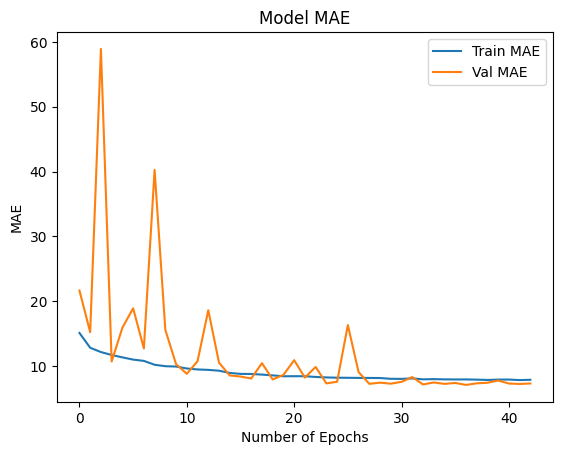

In [19]:
# Plot MAE
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.legend()
plt.xlabel('Number of Epochs')
plt.ylabel('MAE')
plt.title('Model MAE')
plt.show()

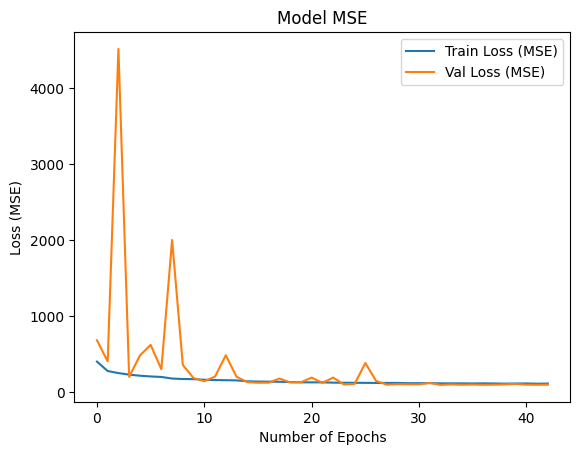

In [20]:
# Plot Loss (MSE)
plt.plot(history.history['loss'], label='Train Loss (MSE)')
plt.plot(history.history['val_loss'], label='Val Loss (MSE)')
plt.legend()
plt.xlabel('Number of Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Model MSE')
plt.show()